# Extended Kalman Filter Raspberry Pi Mouse Version

EKF(Extended Kalman Filter、拡張カルマンフィルタ）はガウシアンフィルタの1つです。

位置推定を行う際にも用いられます。

本ページでは、Raspberry Pi Mouseを用いてロボットがランドマークを観測しながら（拡張）カルマンフィルタで自己位置を推定します。
[raspimouse_http_controller](https://github.com/Tiryoh/raspimouse_http_controller)と組み合わせて使用します。

注がある場合を除き、本ページに掲載されているコードは[MIT](https://tiryoh.mit-license.org/)ライセンスに、文章は[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.ja)ライセンスに基づいて公開します。


## Requirements

このコードを動作させるにはPython 3を必要とします。

## References

S. Thrun, W. Burgard and D. Fox (著), 上田 (訳): 確率ロボティクス, 毎日コミュニケーションズ, 2007

このJupyter Notebookでは [1D_EKF](https://github.com/Tiryoh/probrobo_note/blob/master/ekf/1D_Extended_Kalman_Filter.ipynb) や [2D_EKF](https://github.com/Tiryoh/probrobo_note/blob/master/ekf/1D_Extended_Kalman_Filter.ipynb) を読んだ前提で処理が進められていきます。
まだ読んでいない場合はそちらから先に読んでください。
実際に動かすことに重きを置いていますので、アルゴリズムの詳細な説明は一部省略されています。

# モジュールのインポート

Jupyter Notebookに必要な各種モジュールをインポートします。

In [1]:
# 数値計算及び描画に必要なモジュール
import numpy as np
import math
from  matplotlib import pyplot as plt
from  matplotlib import patches as patches
from copy import copy
import random

# 通信用
import urllib.request
import time
import argparse
import json
import threading

# JupyterNotebook用モジュール
from matplotlib import animation
from IPython.display import HTML
from IPython import display
plt.rcParams.update({'figure.max_open_warning': 0}) #20枚以上画像を描画しても警告を出さないように設定

# デバッグ用
from pprint import pprint

# ランドマーククラス
ロボットにとって目印となるランドマークを宣言します。
ロボットはこのランドマークの座標をあらかじめ知っています。

In [2]:
class Landmarks:
    """
    landmarks = Landmarks([x1, x2, ... , x])
    引数にランドマークのX座標とY座標を配列で指定
    """
    def __init__(self, array):
        """
        ランドマークの座標を配列で取得
        あとで計算処理しやすくするため、numpyのarrayに変換
        """
        self.positions = np.array(array)
    
    def draw(self, subplot = plt):
        """
        取得したすべてのランドマークの座標をプロット
        """
        xs = [ e for e in self.positions ]
        ys = [ 0.1 for e in self.positions ]
        #subplot.scatter(xs, ys, s=600, marker='*', label='landmarks', color='orange')
        subplot.scatter(xs, ys, s = 200, marker = '^',color = 'black', label = 'landmark')

# ロボット実機を制御するためのクラス

受信用のクラス(Receiver)と送信用のクラス(Sender)を作成します。ラズパイマウスとTCP通信を行います。

In [3]:
class Receiver(object):
    def __init__(self, ip, port):
        print("receiver init")
        self.url = "http://{}:{}".format(ip, port)
        print ("connecting to " + self.url)

    def get_sensor_val(self):
        start = time.time()
        request = urllib.request.Request(self.url)
        response = urllib.request.urlopen(request)
        sensor_dict = json.loads(response.read().decode('utf-8'))
        return sensor_dict

class Sender(object):
    def __init__(self, ip, port):
        print("sender init")
        self.url = "http://{}:{}".format(ip, port)
        print ("connecting to " + self.url)

    def set_motor_power(self, mode):
        response_data = []
        request = urllib.request.Request(self.url)
        obj = {
        "motor_power" : mode
        }
        json_data = json.dumps(obj).encode('utf-8')
        headers = {"Content-Type" : "application/json"}
        request = urllib.request.Request(self.url, data=json_data, headers=headers, method='POST')
        with urllib.request.urlopen(request) as response:
            response_body = response.read().decode('utf-8')
            response_data.append(response_body)
        return response_data

    def set_motor_speed(self, left, right):
        response_data = []
        request = urllib.request.Request(self.url)
        obj = {
        "motor" : {
            "l" : int(left), 
            "r" : int(right)
        }
        }
        json_data = json.dumps(obj).encode('utf-8')
        headers = {"Content-Type" : "application/json"}
        request = urllib.request.Request(self.url, data=json_data, headers=headers, method='POST')
        with urllib.request.urlopen(request) as response:
            response_body = response.read().decode('utf-8')
            response_data.append(response_body)
        return response_data

# 通信用クラスの初期化

ラズパイマウスのIPアドレスと通信用のポートを指定します。

In [4]:
r = Receiver("192.168.22.5", 5000)
s = Sender("192.168.22.5", 5000)
#r = Receiver("127.0.0.1", 5000)
#s = Sender("127.0.0.1", 5000)

receiver init
connecting to http://192.168.22.5:5000
sender init
connecting to http://192.168.22.5:5000


# ロボットのクラス

ロボットを操作するためのクラスです。
今回は説明用のグラフ描画のためのメソッド（`draw_graph`）もこのクラスで取り扱っています。

状態空間モデルの状態遷移確率 : $ {x}_t = g({u}_t, {x}_{t-1})+{\epsilon}_t $


## ロボットを操作するためのクラス

実際のロボットは自身の絶対座標を知るすべはありません。そのため、ロボットを操作するためのクラスではロボットの座標を把握していません。

ロボットを操作するためのクラスに与えることができるのは制御入力ベクトルの${u}_t$です。`move`メソッドに`distance`を引数として与えます。

In [5]:
class Robot:
    """
    ロボットの動作を決めるためのクラス
    """
    def __init__(self, x = 0.0):
        self.ekf = EKF(robot_pos = x)
        self.expected_poses = [np.array(x)]
    
    def move(self, distance):
        # 理論上の位置を計算
        self.expected_poses.append(np.array(self.expected_poses[-1] + distance))
        # ラズパイマウスを0.05秒だけ進ませる
        speed = 400 * distance / 6
        s.set_motor_power(1)
        s.set_motor_speed(speed, speed)
        time.sleep(0.05)
        s.set_motor_speed(0, 0)
        s.set_motor_power(0)
        # 制御入力(distance)に基づき、EKFの予測ステップを適用
        self.ekf.prediction_step(distance)
                
    def observation(self, landmarks):
        """
        ランドマーク観測の際に使用
        """
        obss = []
        # すべてのランドマークについて、観測できるか確認
        for i,landmark in enumerate(landmarks.positions):
            # ランドマークの観測結果を保存
            obs = Observation(landmark)
            # センサの範囲内だったランドマークをリストに追加
            if obs.distance != None:
                obss.append([obs, i])
        for obs in obss:
            # 観測結果を一つずつ使いながらEKFの修正ステップを適用
            self.ekf.update_step(obs[0].distance, landmarks.positions[obs[1]])
        return obss

    def draw_graph(self, subplot, obss):
        x = np.arange(-50, 250, 0.1)
        subplot.scatter(self.expected_poses[-1], 0.1, s = 200, marker = '^',color = 'red',label = 'expected robot motion')
        subplot.plot(x, self.generate_gaussian(self.ekf.bel_x_prev, self.ekf.cov_x_prev), color = 'green', label='bel_x (t-1)')
        subplot.plot(x, self.generate_gaussian(self.ekf.priori_bel_x, self.ekf.priori_cov_x), color = 'blue', label='priori_bel_x')
        subplot.plot(x, self.generate_gaussian(self.ekf.posteriori_bel_x, self.ekf.posteriori_cov_x), color = 'orange', label='posteriori_bel_x ')

    def generate_gaussian(self, bel, cov):
        x = np.arange(-50, 250, 0.1)
        return np.exp(-(bel - x) ** 2 / (2 * cov)) / np.sqrt(2 * np.pi * cov) 

# 観測のためのクラス

ランドマークを観測するためのクラスです。
ロボットの現在地からセンサの観測範囲内にランドマークがあるかどうかをチェックします。

状態空間モデルの計測確率: $ {z}_t = h({x}_t ) + {\delta}_t $

`measure`メソッドの中の`actual_distance`が $z_t$ に、`distance`が $h({x}_t )$ に該当します。

In [6]:
class Observation:
    """
    ロボットの観測
    """
    def __init__(self, sensor_min_value = 15, sensor_max_value = 2000):
        # センサ値の上限と下限を設定
        self.sensor_max_value = sensor_max_value
        self.sensor_min_value = sensor_min_value
        
        # 観測できない場合は観測結果をNoneとし、観測できた場合はこの値を上書きする
        self.distance, self.direction, self.error_ellipse = None, None, None
        
        self.measure()

    def measure(self):
        """
        センサの値を取得して対象物があるかチェックする
        """
        # センサ値が有効値内かどうか確認する
        sensor_data = r.get_sensor_val()
        time.sleep(0.05)
        sensor_average = (sensor_data["lightsensor"]["0"] + sensor_data["lightsensor"]["3"]) / 2
        if not sensor_average < self.sensor_max_value and sensor_av > self.sensor_min_value:
            print('sensor data out of range')
            return # 範囲外だった場合はNoneのまま終了
        
        # センサの値を距離（mm）に変換
        distance = sensor_average ** -0.57 * 3435.3
        
        # センサ値を保存
        self.distance = distance

# カルマンフィルタのクラス

本ページでは直線上を移動するロボットの自己位置推定を行っています。
直線上の移動の場合、非線形関数を線形近似する段階がありません。一般的なカルマンフィルタと同じ計算をしています。

## 予測ステップ
予測ステップでは、1つ前の時間($t-1$)の状態を元に、
事前推定値と事前誤差共分散を求めます。
1つ前の時間($t-1$)の
事後推定値を${{\mu}}_{t-1}$
、
事後誤差共分散を${{\Sigma}_{{\bar{x}}_{t-1}}}$
と表します。
事前推定値を$\bar{{\mu}}_t$、
事前誤差共分散を${{\Sigma}_{\bar{{x}}_t}}$
とすると、

カルマンフィルタの場合は、

\begin{align}
    \bar{{\mu}}_t 
    &=& {A}_t {{\mu}}_{t-1} + {B}_t {u}_{t} \\
    {{\Sigma}_{\bar{{x}}_t}} 
    &=& {A}_t {{\Sigma}_{{{x}}_{t-1}}} {{A}_t}^T+ {R}_t
\end{align}

と表すことができます。

拡張カルマンフィルタの場合は、

\begin{align}
    \bar{{\mu}}_t 
    &=& g({u}_t, {\mu}_{t-1}) \\
    {{\Sigma}_{\bar{{x}}_t}} 
    &=& {G}_t {{\Sigma}_{{{x}}_{t-1}}} {{G}_t}^T+ {R}_t
\end{align}

と表すことができます。
なお、${G}_t$は、状態遷移確率${x}_t$を求める非線形関数$g$のヤコビ行列です。

## 修正ステップ

修正ステップでは、予測ステップを元に、カルマンゲイン、事後推定値、事後誤差共分散を求めます。
カルマンゲインを${K}_t$、
事後推定値を${\mu}_t$、
事後誤差共分散を${\Sigma}_{{x}_t}$
とすると、

カルマンフィルタの場合、

\begin{align}
    {K}_t 
    &=& {{\Sigma}_{\bar{{x}}_t}}{{C}_t}^T({C}_t {{\Sigma}_{\bar{{x}}_t}} {{C}_t}^T + {{Q}_t})^{-1} \\
    {\mu}_t 
    &=& \bar{{\mu}}_t + {K}_t ({z}_t - {{C}_t} \bar{{\mu}}_t) \\
    {{\Sigma}_{{{x}}_t}} 
    &=& (1 - {K}_t {C}_t) {{\Sigma}_{\bar{{x}}_t}} 
\end{align}

と表すことができます。

拡張カルマンフィルタの場合、

\begin{align}
    {K}_t 
    &=& {{\Sigma}_{\bar{{x}}_t}}{{H}_t}^T
    ({H}_t {{\Sigma}_{\bar{{x}}_t}} {{H}_t}^T 
    + {{Q}_t})^{-1} \\
    {\mu}_t 
    &=& \bar{{\mu}}_t + {K}_t ({z}_t - h( \bar{{\mu}}_t)) \\
    {{\Sigma}_{{{x}}_t}} 
    &=& (1 - {K}_t {H}_t) 
    {{\Sigma}_{{\bar{x}}_t}} 
\end{align}

と表すことができます。
${H}_t$ は、ロボットの計測確率 ${z}_t$ を求める非線形関数$h$のヤコビ行列です。

ここで求められた
事後推定値${\mu}_t$
と
事後誤差共分散${{\Sigma}_{{{x}}_t}}$
が、時刻$t$におけるカルマンフィルタ適用後の
事後信念です。

$K$と`kalman_gain` 、$\mu_t$ と `posteriori_bel_x` 、${\Sigma}_{{{x}}_t}$ と`posteriori_cov_x`がそれぞれ対応しています。

カルマンゲインの
${{H}_t {{\Sigma}_{{\bar{x}}_t}} {{H}_t}^T + {{Q}_t}}$
は計測予測の不確かさを表しています。
計測がより確かであれば、不確かさは小さくなり、
カルマンゲインは大きくます。
今回の環境においては、
ロボットがランドマークを観測できると、
計測の不確かさが小さくます。
EKFの修正ステップにおける修正幅が大きくなり、
事後推定値がより真のロボットの位置姿勢に近づいていきます。

In [7]:
class EKF:
    """
    EKFのクラス
    """
    def __init__(self, robot_pos, cov = 0.1, sigma_robot_translation_error = 0.5, sigma_robot_observation_error = 0.9):
        # ロボットの雑音：ロボットのクラスで定義されている値と近いほど正確な位置予測ができる
        # ロボットの制御入力に対する雑音の標準偏差
        self.sigma_robot_translation_error = sigma_robot_translation_error
        # ロボットの観測に対する雑音の標準偏差
        self.sigma_robot_observation_error = sigma_robot_observation_error
        # 初回の事前推定値を計算するための事後推定値
        # 推定位置の初期位置（初期信念）
        self.posteriori_bel_x = robot_pos
        # 初回の事前誤差共分散を計算するための事後誤差共分散
        # 推定値の初期位置の分散（標準偏差**2）
        self.posteriori_cov_x = cov
        
    def prediction_step(self, distance):
        """
        予測ステップ
        """
        # 1つ前の時間の状態を保存
        self.bel_x_prev = self.posteriori_bel_x
        self.cov_x_prev = self.posteriori_cov_x
        # 1つ前の時間の事後推定値を元に、事前推定値を計算
        self.priori_bel_x = self.bel_x_prev + random.gauss(distance, distance * self.sigma_robot_translation_error)
        # 1つ前の時間の事後誤差共分散を元に、事前誤差共分散を計算
        self.priori_cov_x = self.cov_x_prev + self.sigma_robot_translation_error ** 2
        
        # ランドマークを観測できなかったとき用
        self.posteriori_bel_x = self.priori_bel_x
        self.posteriori_cov_x = self.priori_cov_x
        
    def update_step(self, obs, landmark):
        """
        修正ステップ
        """
        # カルマンゲイン
        kalman_gain = self.priori_cov_x / (self.priori_cov_x + self.sigma_robot_observation_error ** 2)
        # 事後推定値
        self.posteriori_bel_x = self.priori_bel_x + kalman_gain * (abs(landmark - self.priori_bel_x) - obs)
        #print(obs ,landmark, self.priori_bel_x, (landmark - self.priori_bel_x))
        # 事後誤差共分散
        self.posteriori_cov_x = (1 - kalman_gain) * self.priori_cov_x

# ロボット操作用コードの実行

1つ前の時間の推定値（信念）を `bel_x(t-1)` として、予測ステップ後の事前推定値を `priori_bel_x` として、修正ステップ後の事後推定値を `posteriori_bel_x` として表します。

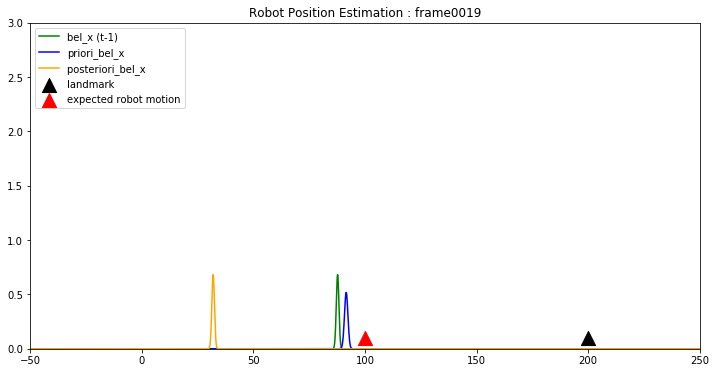

In [14]:
# ランドマークの座標を指定
landmarks = Landmarks([200.0])

# ロボットの初期座標を指定
robot = Robot(0.0)

# アニメーション作成の更新処理
def update(i):
    # 新規ウィンドウと座標軸用subplotを用意
    # タイトルは個別につけるので今は指定しない
    fig, graph = plt.subplots(figsize=(12, 6))
    # 座標軸の範囲を指定
    graph.set_xlim(-50, 250)
    graph.set_ylim(0.0, 3.0)
    # ランドマークを描画
    landmarks.draw(graph)
    # ロボットを移動
    robot.move(5)
    # 移動後の位置でランドマークを観測
    obss = robot.observation(landmarks)
    # ロボットを描画
    robot.draw_graph(graph, obss)
    # タイトルを追加
    graph.set_title("Robot Position Estimation : frame{0:04d}".format(i))
    # 左上に凡例を追加
    graph.legend(loc='upper left')
    

# アニメーションの作成
for i in range(0, 20):
    update(i)
    
    # gifアニメーションのように毎回表示内容を更新する場合は plt.show ではなくこちらを使用
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    # 履歴を全表示する場合は display.display ではなくこちらを使用
    #plt.show()